## **Introduction**

DeepFER: Facial Emotion Recognition Using Deep Learning is a project aimed at developing a robust and efficient system for automatically identifying human emotions from facial expressions. By leveraging advanced deep learning techniques, particularly Convolutional Neural Networks (CNNs) and Transfer Learning, DeepFER is designed to classify emotions such as happiness, sadness, anger, surprise, fear, disgust, and neutrality from facial images.

Facial emotion recognition plays a crucial role in numerous applications, including human-computer interaction, customer service, and mental health monitoring. Traditional approaches relied on handcrafted features and rule-based systems, which often struggled to generalize across diverse faces and real-world conditions. DeepFER addresses these challenges by using deep neural networks to automatically learn hierarchical features from raw image data, achieving high accuracy and real-time performance.

The ultimate goal of DeepFER is to create a versatile and practical tool that allows machines to understand and respond to human emotions, bridging the gap between artificial intelligence and empathetic human-machine interactions.

---

## **Dataset Overview**

DeepFER utilizes the **FER-2013 dataset**, a widely used benchmark for facial emotion recognition. Key characteristics of the dataset are:

* **Image Format:** 48x48 pixel grayscale images
* **Data Alignment:** Faces are automatically registered to be centered and occupy a similar area within the image
* **Dataset Size:**

  * Total: 24,400 images
  * Training set: 22,968 images
  * Public test set: 1,432 images
* **Emotion Classes:**

  1. Angry
  2. Disgust
  3. Fear
  4. Happy
  5. Sad
  6. Surprise
  7. Neutral
* **Data Characteristics:**

  * Grayscale images to simplify computational requirements
  * Poses are consistent to focus on facial expressions
  * Captures both posed and spontaneous expressions for better generalization

The FER-2013 dataset provides a solid foundation for training and evaluating the DeepFER model, allowing for accurate and real-time classification of seven distinct human emotions.




## **Installing Required Libraries**

In [ ]:
# Upgrade pip (optional but recommended)
!pip install --upgrade pip

# Install required libraries
!pip install tensorflow keras opencv-python-headless numpy pandas scikit-learn matplotlib seaborn


## Verify Installations

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)

TensorFlow version: 2.19.0
OpenCV version: 4.12.0
NumPy version: 2.0.2
Pandas version: 2.2.2
Seaborn version: 0.13.2


In [ ]:
import numpy as np             # Numerical operations
import pandas as pd            # Data manipulation / CSV I/O
import os                      # File system operations
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns          # Enhanced visualization
import tensorflow as tf        # Deep learning framework
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
import cv2                     # Image processing
from tensorflow.keras.applications import VGG16, InceptionResNetV2  # For transfer learning
from keras import regularizers                                     # Optional: add weight regularization
from keras.preprocessing import image                               # Alternative to tf.keras.preprocessing

## **Data Ingestion**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = "/content/drive/MyDrive/DeepFER_dataset/train"
test_dir = "/content/drive/MyDrive/DeepFER_dataset/validation"

## **Displaying one image for each emotion in train set**

In [ ]:
import os
class_names = os.listdir("/content/drive/MyDrive/DeepFER_dataset/train")
print(class_names)

['sad', 'surprise', 'neutral', 'happy', 'fear', 'disgust', 'angry']


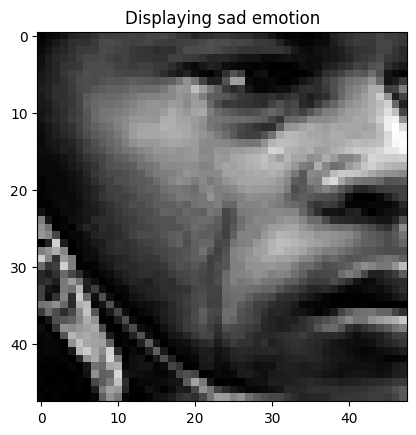

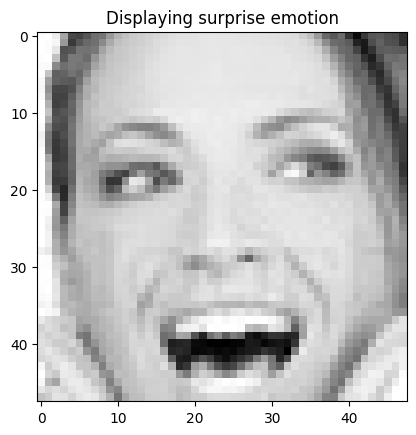

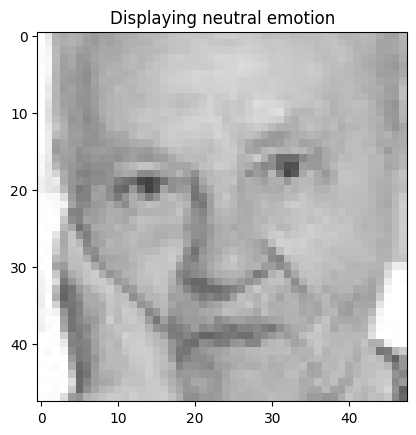

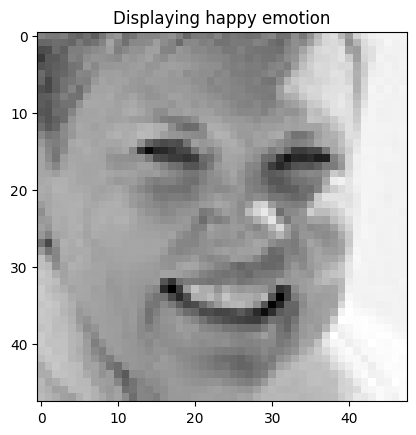

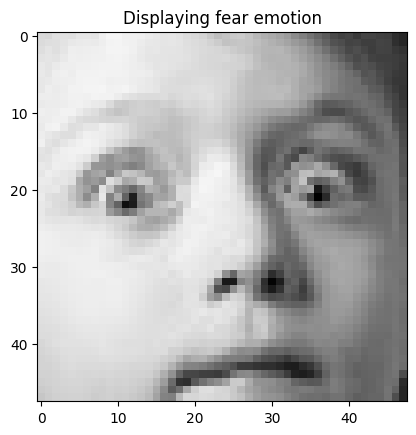

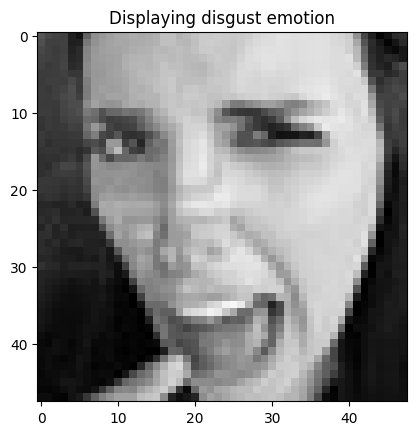

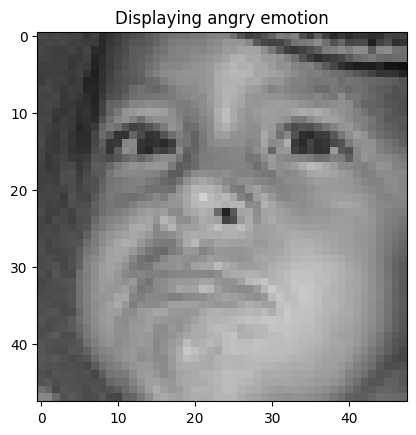

In [ ]:
import glob
dataset_path = "/content/drive/MyDrive/DeepFER_dataset/"
emotions = []
for file_name in glob.glob(dataset_path+'/train/*/*'):
    emotion = file_name.split('/')[-2]
    if emotion not in emotions:
        img = cv2.imread(file_name)
        plt.imshow(img)
        plt.title("Displaying {} emotion".format(emotion))
        plt.show()
    emotions.append(emotion)

## **Data Augmentation & Generators for DeepFER**

In [ ]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    rotation_range=30,           # Randomly rotate images
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Zoom in/out
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill missing pixels
)

In [ ]:
# Validation data generator (no augmentation, only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# ------------------------------
# 3️⃣ Flow Images from Directory
# ------------------------------
batch_size = 64
target_size = (48, 48)  # FER-2013 standard size
color_mode = "grayscale" # FER-2013 is grayscale
class_mode = "categorical"  # Multi-class classification

# Training generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode=class_mode,
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    directory=test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode=class_mode,
    shuffle=False
)

# ------------------------------
# 4️⃣ Class Indices and Labels
# ------------------------------
class_indices = train_generator.class_indices
labels = {v: k for k, v in class_indices.items()}  # Reverse mapping

print("Class Indices:", class_indices)
print("Labels Mapping:", labels)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class Indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Labels Mapping: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


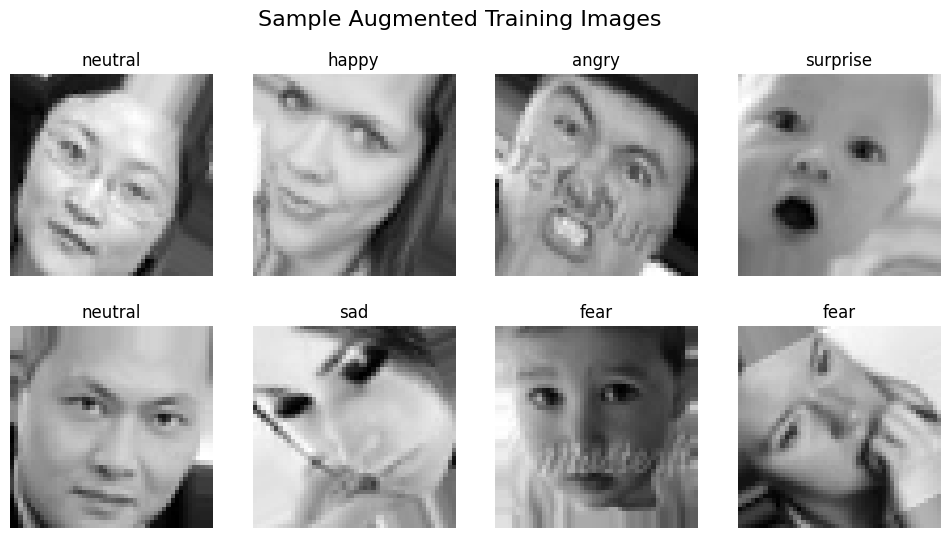

In [ ]:
# ------------------------------
# 5️⃣ Display Some Augmented Images
# ------------------------------
x_batch, y_batch = next(train_generator)  # Get one batch of training images

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i].reshape(48,48), cmap='gray')
    plt.title(labels[y_batch[i].argmax()])
    plt.axis('off')
plt.suptitle("Sample Augmented Training Images", fontsize=16)
plt.show()

In [ ]:
# ------------------------------
# 6️⃣ Input Shape for Model
# ------------------------------
img_shape = train_generator.image_shape
print("Input Shape for Model:", img_shape)

Input Shape for Model: (48, 48, 1)


## **CNN Model Custom Architecture**

To develop the CNN architecture, we will begin by defining the input layer and the number of filters in the first convolutional layer. Then, we will add additional convolutional layers with increasing numbers of filters, followed by max-pooling layers to reduce the spatial dimensions of the feature maps. After the convolutional layers, we will add fully connected layers with ReLU activation to classify the emotions.

We will experiment with different numbers of convolutional layers, filter sizes, and fully connected layers to optimize the model performance. Additionally, we will use techniques such as dropout and batch normalization to prevent overfitting and improve the generalization capability of the model.


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input Layer
inputs = Input(shape=(48, 48, 1), name='input_layer')

# ----------------------------
# Convolutional Block 1
# ----------------------------
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# ----------------------------
# Convolutional Block 2
# ----------------------------
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# ----------------------------
# Convolutional Block 3
# ----------------------------
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# ----------------------------
# Fully Connected Layer
# ----------------------------
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer: 7 classes
outputs = Dense(7, activation='softmax')(x)

# Define Model
model = Model(inputs=inputs, outputs=outputs)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 3,491,335 (13.32 MB)

 Trainable params: 3,489,095 (13.31 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [ ]:
epochs = 42
batch_size = 64

## **CNN Model Training for DeepFER**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# -----------------------------------------
# 📌 Learning Rate Scheduler
# Automatically reduce LR when val accuracy stops improving
# -----------------------------------------
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=8,          # Wait for 8 epochs without improvement
    factor=0.8,          # Reduce LR by 20%
    min_lr=1e-7,         # Minimum allowed LR
    min_delta=1e-7,      # Minimum improvement threshold
    verbose=1
)

# -----------------------------------------
# 💾 Model Checkpoint
# Saves only the version of the model with the best validation accuracy
# -----------------------------------------
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# -----------------------------------------
# 📌 Combine Callbacks
# -----------------------------------------
callbacks_list = [lr_scheduler, checkpoint_callback]


In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,  # <-- correct
    callbacks=callbacks_list,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.2223 - loss: 2.3004 
Epoch 1: val_accuracy improved from -inf to 0.20521, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 6889s 15s/step - accuracy: 0.2224 - loss: 2.2998 - val_accuracy: 0.2052 - val_loss: 2.0563 - learning_rate: 0.0010
Epoch 2/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.3757 - loss: 1.6116
Epoch 2: val_accuracy improved from 0.20521 to 0.49193, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 115s 255ms/step - accuracy: 0.3757 - loss: 1.6115 - val_accuracy: 0.4919 - val_loss: 1.3583 - learning_rate: 0.0010
Epoch 3/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.4642 - loss: 1.4032
Epoch 3: val_accuracy improved from 0.49193 to 0.54132, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 115s 254ms/step - accuracy: 0.4642 - loss: 1.4032 - val_accuracy: 0.5413 - val_loss: 1.2099 - learning_rate: 0.0010
Epoch 4/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5038 - loss: 1.3064
Epoch 4: val_accuracy did not improve from 0.54132
451/451 ━━━━━━━━━━━━━━━━━━━━ 114s 253ms/step - accuracy: 0.5039 - loss: 1.3064 - val_accuracy: 0.5381 - val_loss: 1.1904 - learning_rate: 0.0010
Epoch 5/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5307 - loss: 1.2403
Epoch 5: val_accuracy did not improve from 0.54132
451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 248ms/step - accuracy: 0.5307 - loss: 1.2403 - val_accuracy: 0.5341 - val_loss: 1.2352 - learning_rate: 0.0010
Epoch 6/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5431 - loss: 1.2050
Epoch 6: val_accuracy improved from 0.54132 to 0.55250, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 247ms/step - accuracy: 0.5431 - loss: 1.2050 - val_accuracy: 0.5525 - val_loss: 1.1826 - learning_rate: 0.0010
Epoch 7/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5611 - loss: 1.1705
Epoch 7: val_accuracy did not improve from 0.55250
451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 251ms/step - accuracy: 0.5611 - loss: 1.1705 - val_accuracy: 0.5175 - val_loss: 1.2498 - learning_rate: 0.0010
Epoch 8/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5548 - loss: 1.1698
Epoch 8: val_accuracy improved from 0.55250 to 0.58944, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 251ms/step - accuracy: 0.5548 - loss: 1.1698 - val_accuracy: 0.5894 - val_loss: 1.0895 - learning_rate: 0.0010
Epoch 9/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5647 - loss: 1.1464
Epoch 9: val_accuracy improved from 0.58944 to 0.59440, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.5647 - loss: 1.1464 - val_accuracy: 0.5944 - val_loss: 1.0761 - learning_rate: 0.0010
Epoch 10/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5760 - loss: 1.1189
Epoch 10: val_accuracy did not improve from 0.59440
451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 250ms/step - accuracy: 0.5760 - loss: 1.1188 - val_accuracy: 0.4642 - val_loss: 1.3810 - learning_rate: 0.0010
Epoch 11/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5823 - loss: 1.1042
Epoch 11: val_accuracy improved from 0.59440 to 0.60119, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 248ms/step - accuracy: 0.5823 - loss: 1.1042 - val_accuracy: 0.6012 - val_loss: 1.0807 - learning_rate: 0.0010
Epoch 12/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5971 - loss: 1.0722
Epoch 12: val_accuracy did not improve from 0.60119
451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 250ms/step - accuracy: 0.5971 - loss: 1.0722 - val_accuracy: 0.5843 - val_loss: 1.1237 - learning_rate: 0.0010
Epoch 13/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5939 - loss: 1.0742
Epoch 13: val_accuracy did not improve from 0.60119
451/451 ━━━━━━━━━━━━━━━━━━━━ 111s 247ms/step - accuracy: 0.5939 - loss: 1.0742 - val_accuracy: 0.6012 - val_loss: 1.0588 - learning_rate: 0.0010
Epoch 14/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6009 - loss: 1.0630
Epoch 14: val_accuracy improved from 0.60119 to 0.60855, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 114s 252ms/step - accuracy: 0.6009 - loss: 1.0630 - val_accuracy: 0.6085 - val_loss: 1.0738 - learning_rate: 0.0010
Epoch 15/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6051 - loss: 1.0470
Epoch 15: val_accuracy improved from 0.60855 to 0.61548, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 250ms/step - accuracy: 0.6051 - loss: 1.0470 - val_accuracy: 0.6155 - val_loss: 1.0419 - learning_rate: 0.0010
Epoch 16/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6152 - loss: 1.0331
Epoch 16: val_accuracy did not improve from 0.61548
451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.6152 - loss: 1.0332 - val_accuracy: 0.6056 - val_loss: 1.0560 - learning_rate: 0.0010
Epoch 17/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6116 - loss: 1.0306
Epoch 17: val_accuracy did not improve from 0.61548
451/451 ━━━━━━━━━━━━━━━━━━━━ 114s 252ms/step - accuracy: 0.6116 - loss: 1.0306 - val_accuracy: 0.6019 - val_loss: 1.0627 - learning_rate: 0.0010
Epoch 18/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6119 - loss: 1.0130
Epoch 18: val_accuracy improved from 0.61548 to 0.62723, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 247ms/step - accuracy: 0.6119 - loss: 1.0130 - val_accuracy: 0.6272 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 19/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6294 - loss: 0.9949
Epoch 19: val_accuracy improved from 0.62723 to 0.63643, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 247ms/step - accuracy: 0.6294 - loss: 0.9949 - val_accuracy: 0.6364 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 20/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6223 - loss: 1.0035
Epoch 20: val_accuracy did not improve from 0.63643
451/451 ━━━━━━━━━━━━━━━━━━━━ 110s 245ms/step - accuracy: 0.6223 - loss: 1.0035 - val_accuracy: 0.6295 - val_loss: 0.9931 - learning_rate: 0.0010
Epoch 21/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6293 - loss: 0.9927
Epoch 21: val_accuracy did not improve from 0.63643
451/451 ━━━━━━━━━━━━━━━━━━━━ 111s 246ms/step - accuracy: 0.6293 - loss: 0.9926 - val_accuracy: 0.6327 - val_loss: 0.9780 - learning_rate: 0.0010
Epoch 22/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6348 - loss: 0.9755
Epoch 22: val_accuracy did not improve from 0.63643
451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 248ms/step - accuracy: 0.6348 - loss: 0.9756 - val_accuracy: 0.6248 - val_loss: 1.0057 - learning_rate: 0.00

451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 248ms/step - accuracy: 0.6459 - loss: 0.9452 - val_accuracy: 0.6402 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 26/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6515 - loss: 0.9422
Epoch 26: val_accuracy did not improve from 0.64025
451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.6515 - loss: 0.9422 - val_accuracy: 0.6306 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 27/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6522 - loss: 0.9318
Epoch 27: val_accuracy improved from 0.64025 to 0.64308, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 248ms/step - accuracy: 0.6522 - loss: 0.9319 - val_accuracy: 0.6431 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 28/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6545 - loss: 0.9254
Epoch 28: val_accuracy did not improve from 0.64308
451/451 ━━━━━━━━━━━━━━━━━━━━ 111s 246ms/step - accuracy: 0.6544 - loss: 0.9254 - val_accuracy: 0.6025 - val_loss: 1.0748 - learning_rate: 0.0010
Epoch 29/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6553 - loss: 0.9161
Epoch 29: val_accuracy did not improve from 0.64308
451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 248ms/step - accuracy: 0.6553 - loss: 0.9161 - val_accuracy: 0.6343 - val_loss: 0.9721 - learning_rate: 0.0010
Epoch 30/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6568 - loss: 0.9208
Epoch 30: val_accuracy did not improve from 0.64308
451/451 ━━━━━━━━━━━━━━━━━━━━ 115s 254ms/step - accuracy: 0.6567 - loss: 0.9208 - val_accuracy: 0.6361 - val_loss: 0.9829 - learning_rate: 0.00

451/451 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - accuracy: 0.6550 - loss: 0.9271 - val_accuracy: 0.6476 - val_loss: 0.9685 - learning_rate: 0.0010
Epoch 32/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6597 - loss: 0.9113
Epoch 32: val_accuracy improved from 0.64761 to 0.64832, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 115s 255ms/step - accuracy: 0.6597 - loss: 0.9113 - val_accuracy: 0.6483 - val_loss: 0.9651 - learning_rate: 0.0010
Epoch 33/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6625 - loss: 0.9051
Epoch 33: val_accuracy improved from 0.64832 to 0.65284, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 115s 254ms/step - accuracy: 0.6625 - loss: 0.9051 - val_accuracy: 0.6528 - val_loss: 0.9452 - learning_rate: 0.0010
Epoch 34/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6643 - loss: 0.8983
Epoch 34: val_accuracy did not improve from 0.65284
451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 249ms/step - accuracy: 0.6643 - loss: 0.8983 - val_accuracy: 0.6502 - val_loss: 0.9617 - learning_rate: 0.0010
Epoch 35/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6646 - loss: 0.8911
Epoch 35: val_accuracy did not improve from 0.65284
451/451 ━━━━━━━━━━━━━━━━━━━━ 111s 247ms/step - accuracy: 0.6646 - loss: 0.8911 - val_accuracy: 0.6243 - val_loss: 1.0277 - learning_rate: 0.0010
Epoch 36/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6764 - loss: 0.8682
Epoch 36: val_accuracy improved from 0.65284 to 0.65766, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 111s 247ms/step - accuracy: 0.6764 - loss: 0.8682 - val_accuracy: 0.6577 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 37/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6742 - loss: 0.8760
Epoch 37: val_accuracy did not improve from 0.65766
451/451 ━━━━━━━━━━━━━━━━━━━━ 112s 248ms/step - accuracy: 0.6742 - loss: 0.8760 - val_accuracy: 0.6455 - val_loss: 0.9716 - learning_rate: 0.0010
Epoch 38/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6708 - loss: 0.8785
Epoch 38: val_accuracy improved from 0.65766 to 0.65822, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 114s 252ms/step - accuracy: 0.6708 - loss: 0.8785 - val_accuracy: 0.6582 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 39/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6830 - loss: 0.8519
Epoch 39: val_accuracy did not improve from 0.65822
451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 251ms/step - accuracy: 0.6830 - loss: 0.8519 - val_accuracy: 0.6541 - val_loss: 0.9679 - learning_rate: 0.0010
Epoch 40/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6775 - loss: 0.8672
Epoch 40: val_accuracy did not improve from 0.65822
451/451 ━━━━━━━━━━━━━━━━━━━━ 113s 250ms/step - accuracy: 0.6775 - loss: 0.8671 - val_accuracy: 0.6582 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 41/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6850 - loss: 0.8462
Epoch 41: val_accuracy improved from 0.65822 to 0.66671, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 114s 253ms/step - accuracy: 0.6850 - loss: 0.8463 - val_accuracy: 0.6667 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 42/42
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6832 - loss: 0.8477
Epoch 42: val_accuracy improved from 0.66671 to 0.66870, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 114s 253ms/step - accuracy: 0.6832 - loss: 0.8477 - val_accuracy: 0.6687 - val_loss: 0.9261 - learning_rate: 0.0010


## **Model Evaluation Section**

## **Evaluate the model on validation data**

In [ ]:
# Evaluate performance on validation set
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.6222 - loss: 1.0368
Validation Accuracy: 0.6687
Validation Loss: 0.9261


## **Plot Accuracy & Loss Curves**

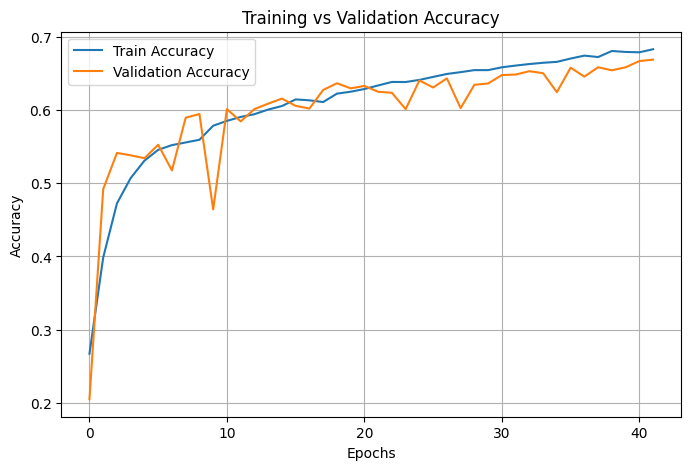

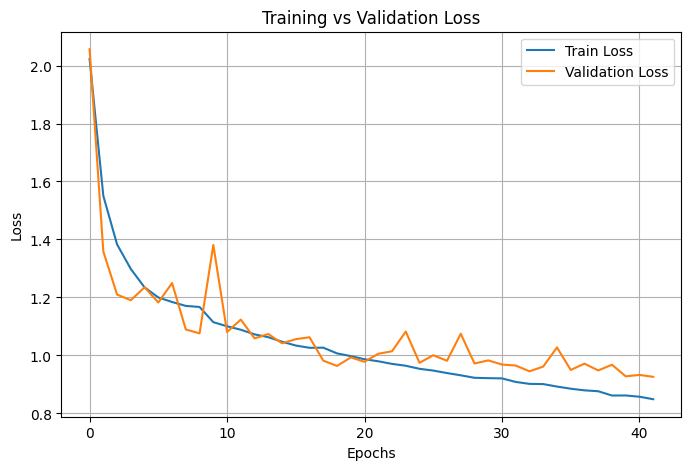

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss Plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# True labels from generator
true_labels = val_generator.classes

# Predictions
pred_probs = model.predict(val_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Class label mapping
class_names = list(val_generator.class_indices.keys())

print(classification_report(true_labels, pred_labels, target_names=class_names))


111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step
              precision    recall  f1-score   support

       angry       0.55      0.61      0.58       960
     disgust       0.78      0.58      0.66       111
        fear       0.60      0.36      0.45      1018
       happy       0.88      0.88      0.88      1825
     neutral       0.56      0.72      0.63      1216
         sad       0.55      0.54      0.55      1139
    surprise       0.77      0.76      0.77       797

    accuracy                           0.67      7066
   macro avg       0.67      0.64      0.64      7066
weighted avg       0.67      0.67      0.66      7066



## **Confusion Matrix**


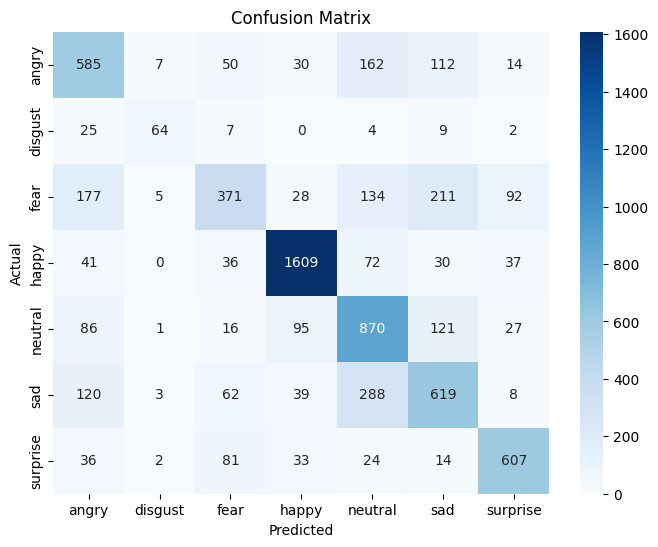

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Testing Random Validation Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the emotion labels
labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}



# Get the batch size from the validation generator
batch_size = validation_generator.batch_size

# Generate random batch and image indices
random_batch = np.random.randint(0, len(validation_generator) - 1)
random_img_indices = np.random.randint(0, batch_size, 10)

# Create a plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Get a random image and its true label from the validation data
    random_img = validation_generator[random_batch][0][random_img_indices[i]]
    random_img_label = np.argmax(validation_generator[random_batch][1][random_img_indices[i]])
    print(type(random_img))
    # Predict the label using the model
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0))

    # Display the image
    ax.imshow(random_img.squeeze(), cmap='gray')

    # Determine the color of the title (green if correct, red if incorrect)
    if labels[random_img_label] == labels[model_prediction]:
        color = "green"
    else:
        color = "red"

    # Set the title of the subplot
    ax.set_title(f"True: {labels[random_img_label]}\nPredicted: {labels[model_prediction]}", color=color)

# Show the plot
plt.tight_layout()
plt.show()


## Saving the Model

In [ ]:
# Save the entire model
model.save('cnn_model_new_.h5')

In [ ]:

face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/DeepFER_dataset/real-time/haarcascade_frontalface_default.xml')